## Non-Parametric Distribution Estimation - Taxi Rides Durations

### Initialization 

In [ ]:
# Importing packages
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (5.0, 5.0)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations and pandas tables in cells output
from IPython.core.display import display, HTML, Latex

## Setting style (not relevant in Colab)
display(HTML('<link rel="stylesheet" href="../../../css/style.css">'))  ## Use the same style as the rest of the site (mostly for titiles)
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; }</style>"))  ## Center output figures

### Preparing the Dataset

Preparing the NYC taxi rides dataset.

#### Loading the data

- The data can be found at [https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv](https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv) 

In [ ]:
data_file = 'https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv'

## Loading the data
dataset = pd.read_csv(data_file)

#### Previewing the data

printing out the 10 first rows.

In [ ]:
## Print the number of rows in the data set
number_of_rows = len(dataset)
display(Latex('Number of rows in the dataset: $N={}$'.format(number_of_rows)))

## Show the first 10 rows
display(HTML(dataset.head(10).to_html()))

<IPython.core.display.Latex object>

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,pickup_easting,pickup_northing,dropoff_easting,dropoff_northing,duration,day_of_week,day_of_month,time_of_day
0,2,2.768065,2,9.5,0.00,586.996941,4512.979705,588.155118,4515.180889,11.516667,3,13,12.801944
1,1,3.218680,2,10.0,0.00,587.151523,4512.923924,584.850489,4512.632082,12.666667,6,16,20.961389
2,1,2.574944,1,7.0,2.49,587.005357,4513.359700,585.434188,4513.174964,5.516667,0,31,20.412778
3,1,0.965604,1,7.5,1.65,586.648975,4511.729212,586.671530,4512.554065,9.883333,1,25,13.031389
4,1,2.462290,1,7.5,1.66,586.967178,4511.894301,585.262474,4511.755477,8.683333,2,5,7.703333
5,5,1.561060,1,7.5,2.20,585.926415,4512.880385,585.168973,4511.540103,9.433333,3,20,20.667222
6,1,2.574944,1,8.0,1.00,586.731409,4515.084445,588.710175,4514.209184,7.950000,5,8,23.841944
7,1,0.804670,2,5.0,0.00,585.344614,4509.712541,585.843967,4509.545089,4.950000,5,29,15.831389
8,1,3.653202,1,10.0,1.10,585.422062,4509.477536,583.671081,4507.735573,11.066667,5,8,2.098333
9,6,1.625433,1,5.5,1.36,587.875433,4514.931073,587.701248,4513.709691,4.216667,3,13,21.783056


####  Splitting the dataset

We will split the data into 80% train set and 20% test set for later evaluations

In [ ]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed (this is important to make our result reproducible)
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = rand_gen.permutation(n_samples)

## Split the indices into 80% train / 20% test
n_samples_train = int(n_samples * 0.8)
train_indices = indices[:n_samples_train]
test_indices = indices[n_samples_train:]

train_set = dataset.iloc[train_indices]
test_set = dataset.iloc[test_indices]

### ECFD

Calculating the ECDF over a grid of durations.

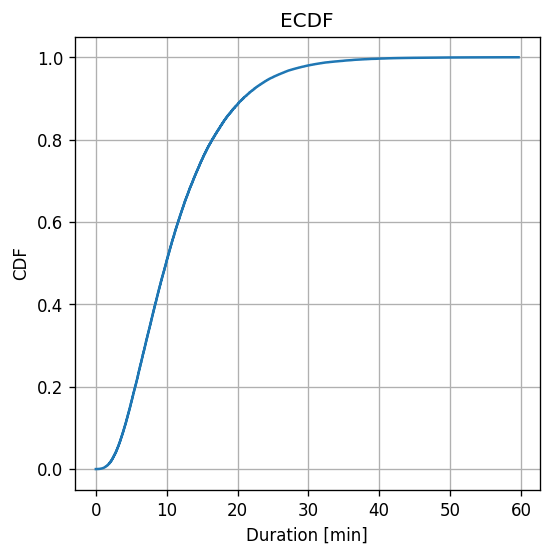

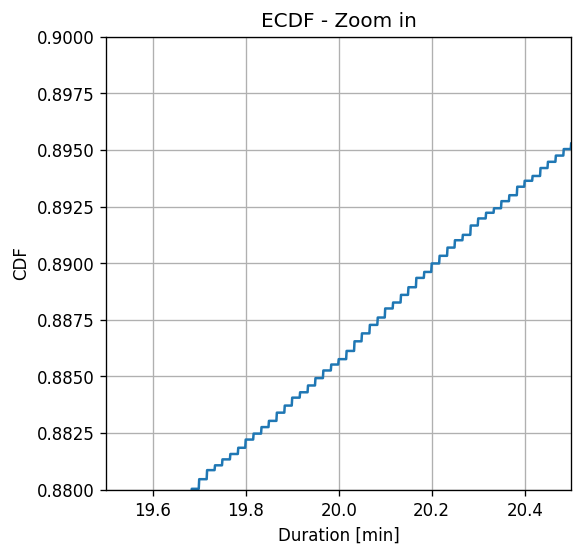

In [ ]:
def calculate_ecdf(x, duration_grid):
    
    ## Initialize a an array for the calculated ECDF
    ecdf = np.zeros(duration_grid.shape)
    
    ## Calculate the ECDF by definition
    for i, duration in enumerate(duration_grid):   # enumerate adds an index to the list's values
        ecdf[i] = (x <= duration).mean()
    
    return ecdf
    

## extarcting the samples
x = train_set['duration'].values

## Define the grid
duration_grid = np.arange(0, x.max() + 0.001, 0.001)  # We add the step size to the end of the range to include the endpoint

## Create the ECDF
ecdf = calculate_ecdf(x, duration_grid)

# plot the ECDF
fig, ax = plt.subplots()
ax.plot(duration_grid, ecdf)
ax.set_title('ECDF')
ax.set_ylabel('CDF')
ax.set_xlabel('Duration [min]')
fig.savefig('../media/ecdf.png')

## Plot a zoomed in version
fig, ax = plt.subplots()
ax.plot(duration_grid, ecdf)
ax.set_title('ECDF - Zoom in')
ax.set_ylabel('CDF')
ax.set_xlabel('Duration [min]')
ax.set_xlim(19.5, 20.5)
ax.set_ylim(0.88, 0.9);
fig.savefig('../media/ecdf_zoom.png')

#### ECDF with smaller amount of data

Recalculate the EDCF with N = 10, 100 and 1000 samples from the train set.

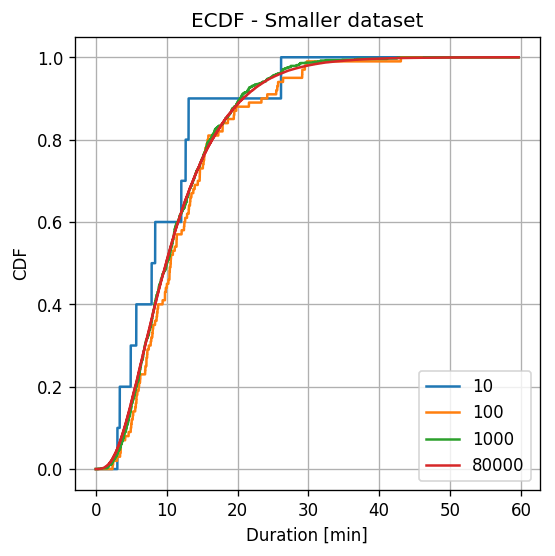

In [ ]:
## Create the figure and axis
fig, ax = plt.subplots()
ax.set_title('ECDF - Smaller dataset')
ax.set_ylabel('CDF')
ax.set_xlabel('Duration [min]')

## Generate a random generator for the sampling
rand_gen = np.random.RandomState(0)

for n_samples in [10, 100, 1000, len(x)]:
    x_smaller = rand_gen.choice(x, n_samples, replace=False)
    
    ## Create the ECDF
    ecdf = calculate_ecdf(x_smaller, duration_grid)

    ## Plot the ECDF
    ax.plot(duration_grid, ecdf, label=str(n_samples))

## Add a legend
ax.legend();
fig.savefig('../media/ecdf_subsets.png')

### Histogram

Estimating the PDF of the distribution using an histograms.

We will calculate it for 30, 300 and 3000 bins

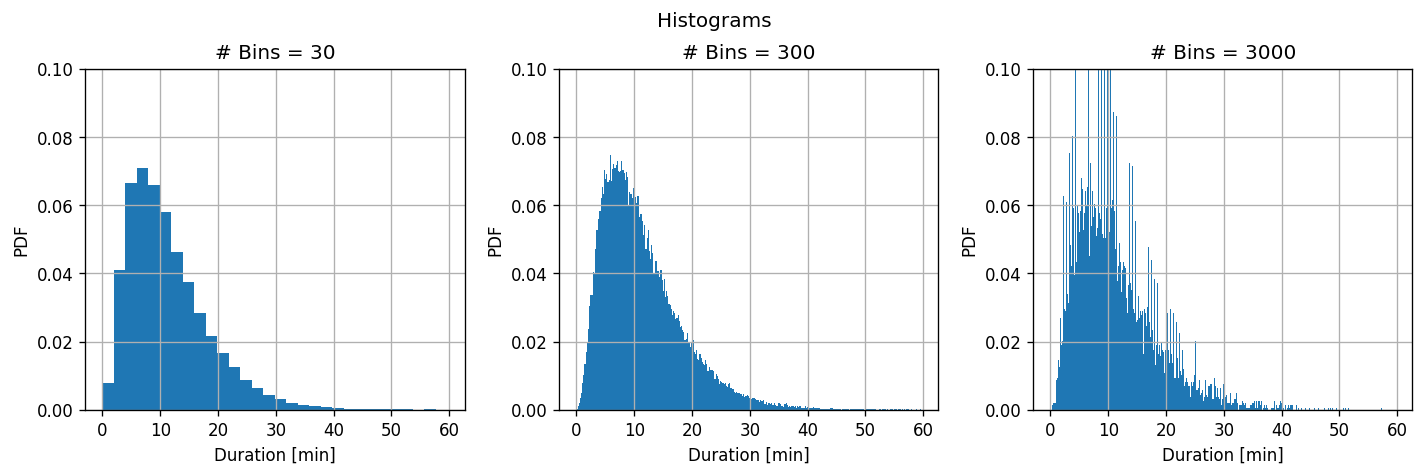

In [ ]:
def calculate_hist(x, n_bins):
    ## Define bins
    bins_edges = np.linspace(0, x.max() + 1e-9, n_bins + 1)
    bins_width = np.diff(bins_edges) ## Equal to running: bins[1:] - bins[:-1]

    ## Calculate the histogram
    hist_values = np.zeros(n_bins)
    for k in range(n_bins):
        hist_values[k] = \
            np.sum((x >= bins_edges[k]) & 
                   (x < bins_edges[k + 1])
                   ) / n_samples / bins_width[k]
    
    return hist_values, bins_edges, bins_width

## Prepare the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
## Loop over the number of bins
for i_bins, n_bins in enumerate((30, 300, 3000)):
    ## Calculate the histogram
    hist_values, bins_edges, bins_width = calculate_hist(x, n_bins)
    
    ## Plot the histogram
    ax[i_bins].bar(bins_edges[:-1], hist_values, width=bins_width, align='edge');
    ax[i_bins].set_title('# Bins = {}'.format(n_bins))
    ax[i_bins].set_ylabel('PDF')
    ax[i_bins].set_xlabel('Duration [min]')
    ax[i_bins].set_ylim(0, 0.1)

fig.suptitle('Histograms');
plt.tight_layout(rect=(0, 0, 1, 0.95))
fig.savefig('../media/histograms.png')

From here on we will use the [plt.hist](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html?highlight=hist#matplotlib.axes.Axes.hist) or [numpy.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) functions for calculating histograms.

#### Histograms of data subsets

We will split the train set into 8 subsets and calculate the histograms for each subset.

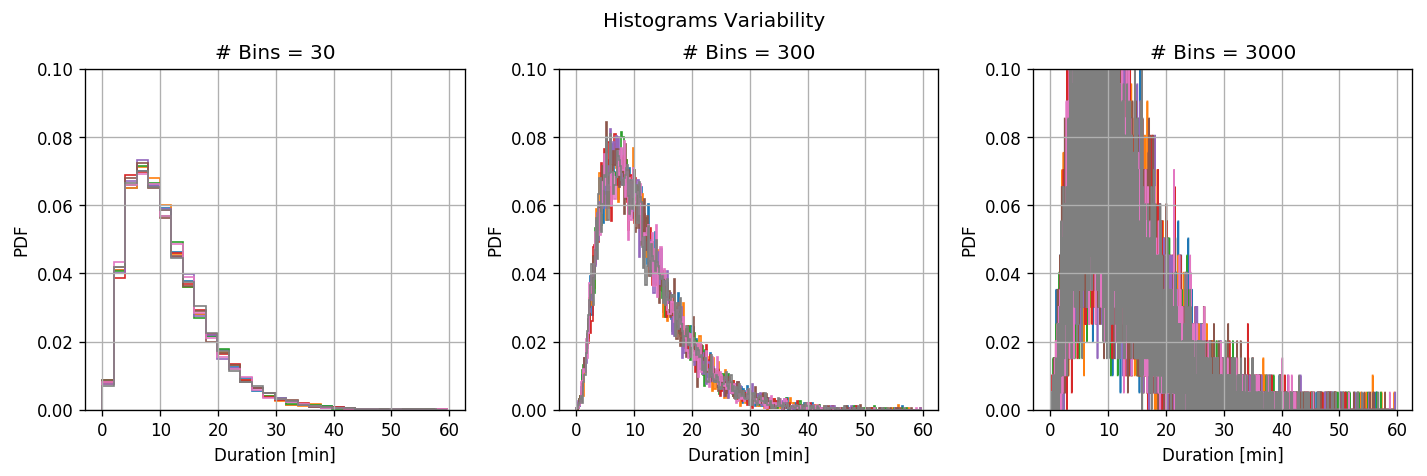

In [ ]:
## Generate a random generator for the shuffling
rand_gen = np.random.RandomState(0)
## Shuffle the array (the array is copied in order to preserve the order of the original array)
x_shuffled = x.copy()
rand_gen.shuffle(x_shuffled)
## Split the shuffled array
x_splited = np.split(x_shuffled, 8)

## Prepare the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
## Loop over the number of bins
for i_bins, n_bins in enumerate([30, 300, 3000]):
    ## Define bins
    bins_edges = np.linspace(0, x.max() + 1e-9, n_bins + 1)
    
    ## Loop over the subsets
    for x_subset in x_splited:
        ## Plot histogram
        ax[i_bins].hist(x_subset, bins=bins_edges, density=True, histtype='step', fill=False);
    ax[i_bins].set_title('# Bins = {}'.format(n_bins))
    ax[i_bins].set_ylabel('PDF')
    ax[i_bins].set_xlabel('Duration [min]')
    ax[i_bins].set_ylim(0, 0.1)

fig.suptitle('Histograms Variability');
plt.tight_layout(rect=(0, 0, 1, 0.95))
fig.savefig('../media/histograms_subsets.png')

To better visualize the variance let us plot the above graphs after removing the mean value:

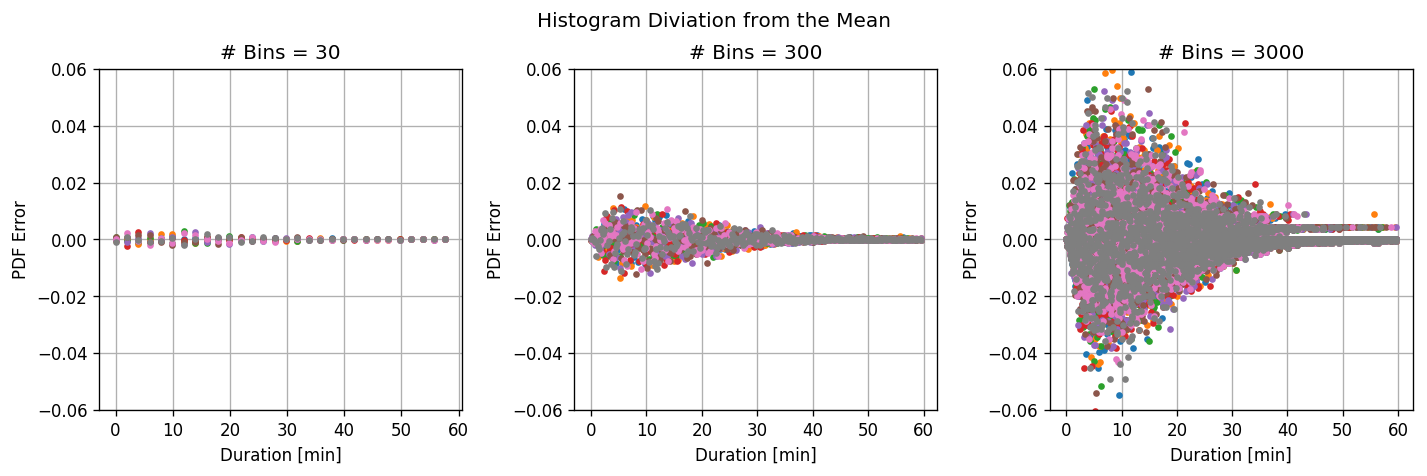

In [ ]:
## Prepare the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
## Loop over the number of bins
for i_bins, n_bins in enumerate([30, 300, 3000]):
    ## Define bins
    bins_edges = np.linspace(0, x.max() + 1e-9, n_bins + 1)
    
    ## Initialize an array to store the histograms values
    histograms = np.zeros((len(x_splited), len(bins_edges) - 1))
    
    ## Loop over the subsets
    for i_subset, x_subset in enumerate(x_splited):
        ## Calculate the histograms
        histograms[i_subset] = np.histogram(x_subset, bins=bins_edges, density=True)[0]

    ## Remove the mean value
    histograms_error = histograms - histograms.mean(axis=0)
    
    ## Plot the histograms error
    ax[i_bins].plot(bins_edges[:-1], histograms_error.T, '.')
    ax[i_bins].set_title('# Bins = {}'.format(n_bins))
    ax[i_bins].set_ylabel('PDF Error')
    ax[i_bins].set_xlabel('Duration [min]')
    ax[i_bins].set_ylim(-0.06, 0.06)

fig.suptitle('Histogram Diviation from the Mean');
plt.tight_layout(rect=(0, 0, 1, 0.95))
fig.savefig('../media/histograms_subsets2.png')

### KDE

Estimating the PDF of the distribution using an KDE.

We will calculate it using a Gaussian Parzen window with widths ($\sigma$) of 0.08, 0.8, 8.

<IPython.core.display.Latex object>

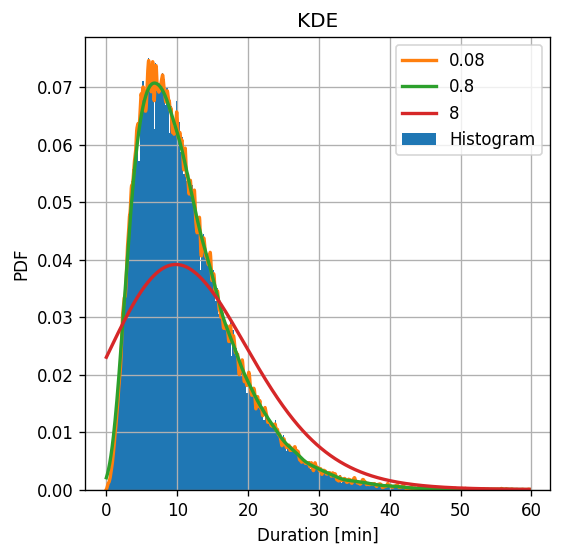

In [ ]:
## Calculate the suggested bandwidth
suggested_bandwidth = 1.06 * np.std(x) / n_samples ** (1 / 5.)
display(Latex('The rule of thumb suggests a bandwidth of $\\left(\\frac{{4\\cdot\\text{{std}}\\left\\{{x_i\\right\\}}}}{{3N}}\\right)^\\frac{{1}}{{5}}\\approx{:.3f}$'.format(suggested_bandwidth)))

def calculate_gaussian_kde(x, bandwidth, duration_grid):
    ## Calculate a matrix of (x_grid_j - x_i)^2 
    delta_squared = (duration_grid[:, None] - x[None, :]) ** 2

    ## Calculate the KDE
    kde = (1 / np.sqrt(2 * np.pi * bandwidth ** 2) * np.exp(- delta_squared / 2 / bandwidth ** 2)).mean(axis=1)
    
    return kde

## Define the grid
duration_grid = np.arange(0, x.max() + 0.01, 0.01)

## Prepare the figure
fig, ax = plt.subplots()
ax.hist(x, bins=300 ,density=True, label='Histogram')
## Loop over the bandwidth
for i_bandwidth, bandwidth in enumerate([0.08, 0.8, 8]):
    ## Calculate KDE
    kde = calculate_gaussian_kde(x, bandwidth, duration_grid)
    
    ## Plot histogram
    ax.plot(duration_grid, kde, linewidth=2, label=str(bandwidth))

ax.set_title('KDE')
ax.set_ylabel('PDF')
ax.set_xlabel('Duration [min]')
ax.legend();
fig.savefig('../media/kde.png')

From here on we will use the [KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity) object from scikit-learn to calculate KDEs.

### Problem: Work Hours Prediction

Estimating $p_Y\left(y\right)$ using the empirical measure estimation: $\frac{1}{N}\sum_i I\left\{y_i=y\right\}$

In [ ]:
## Define {y}
y = (train_set['time_of_day'].values > 7) & (train_set['time_of_day'].values < 18)

## Calculate the probability p_Y(1)
prob_y1 = y.mean()
display(Latex('$p_Y(1)\\approx{:.2f}$'.format(prob_y1)))

## Calculate the probability p_Y(0)
prob_y0 = (~y).mean()
display(Latex('$p_Y(0)\\approx{:.2f}$'.format(prob_y0)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Performance evaluation - Constant Prediction

Testing the prediction method on the test set, using the misclassification rate risk:

In [ ]:
## Define {y} for the test set
y_test = (test_set['time_of_day'].values > 7) & (test_set['time_of_day'].values < 18)

predictions = 1
test_risk = (y_test != predictions).mean()
display(Latex('The test risk is: $R_\\text{{test}}\\{{ \\hat{{y}}=1 \\}}={:.2}$'.format(test_risk)))

<IPython.core.display.Latex object>

Evaluating $p_{X|Y}\left(x|y=1\right)$ by calculating a KDE using only the samples with $Y=1$, and the same for $p_{X|Y}\left(x|y=0\right)$ 

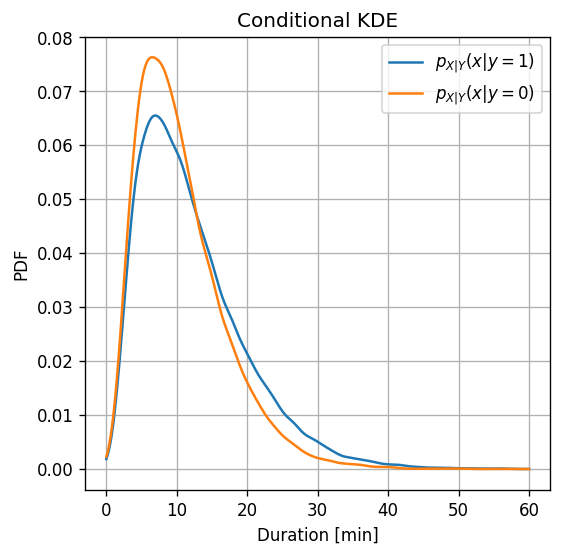

In [ ]:
## Import the KDE class from scikit-learn
from sklearn.neighbors import KernelDensity

## Define the grid
duration_grid = np.arange(0, 60 + 0.1, 0.1)

## Initialize a KDE estimation object
kde_func = KernelDensity(kernel='gaussian', bandwidth=0.8)

## Y=1
## Update the KDE object with the data for Y=1
kde_func.fit(x[y, None])
## Calculate the desity over the grid
kde_y1 = np.exp(kde_func.score_samples(duration_grid[:, None]))  ## score_samples retuns log(p(x))

## Y=0
## Update the KDE object with the data for Y=1
kde_func.fit(x[~y, None])
## Calculate the desity over the grid
kde_y0 = np.exp(kde_func.score_samples(duration_grid[:, None]))  ## score_samples retuns log(p(x))

fig, ax = plt.subplots()
ax.plot(duration_grid, kde_y1, label='$p_{X|Y}(x|y=1)$')
ax.plot(duration_grid, kde_y0, label='$p_{X|Y}(x|y=0)$')
ax.set_title('Conditional KDE')
ax.set_ylabel('PDF')
ax.set_xlabel('Duration [min]')
ax.legend();
fig.savefig('../media/conditional_kde.png')

Evaluating

$$
\hat{y}=\underset{y}{\arg\max}\quad p\left(x\lvert y\right)p\left(y\right)
$$

numerically by substituting the quantities which we have already calculated into this inequality:

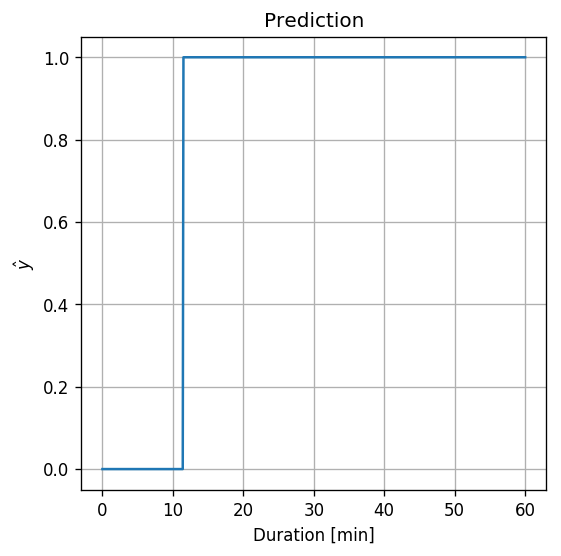

In [ ]:
## Calculate the prediction over the grid
prediction = kde_y1 * prob_y1 >= kde_y0 * prob_y0

## Plot the prediction
fig, ax = plt.subplots()
ax.plot(duration_grid, prediction)
ax.set_title('Prediction')
ax.set_ylabel('$\hat{y}$')
ax.set_xlabel('Duration [min]');
fig.savefig('../media/prediction.png')

#### Performance evaluation - Based on Duration

Testing our prediction method on the test set:

In [ ]:
x_test = test_set['duration'].values

predictions = x_test > 11.4
test_risk = (y_test != predictions).mean()
display(Latex('The test risk is: $R_\\text{{test}}\\{{ \\hat{{y}}(x) \\}}={:.2}$'.format(test_risk)))

<IPython.core.display.Latex object>